In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams['font.family'] = 'Rubik'
import seaborn as sns
sns.set(font="Rubik")
import re

In [8]:
def position_mapping(x):
    if 'C' in x:
        return 'Center'
    elif 'F' in x:
        return 'Forward'
    elif 'G' in x:
        return 'Guard'

In [9]:
data = pd.read_csv('./../../data/player_seasonal_stats_advanced.csv')
data['Position'] = data['Pos'].apply(lambda x: position_mapping(x))
data = data[['Player', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%','OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Position']]
data['Player'] = data['Player'].apply(lambda x: x.replace('*', ''))
print(data.shape[0], 'rows')
data = data.drop_duplicates(subset=['Player'], keep='last').reset_index(drop=True)
print(data.shape[0], 'rows')
data

11526 rows
2337 rows


,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position
0,Chris Anstey,25,73,1007,15.1,0.512,0.016,0.404,10.3,22.5,...,23.1,0.6,1.3,1.9,0.090,-2.1,-0.1,-2.3,-0.1,Center
1,B.J. Armstrong,32,27,583,10.7,0.510,0.156,0.134,0.4,9.2,...,18.6,0.2,0.2,0.4,0.030,-1.8,-2.0,-3.8,-0.3,Guard
2,Anthony Avent,30,49,377,5.5,0.368,0.000,0.333,6.6,15.6,...,15.8,-0.7,0.2,-0.5,-0.065,-6.9,-0.5,-7.4,-0.5,Forward
3,Toby Bailey,24,46,449,10.8,0.483,0.071,0.464,6.6,11.2,...,18.9,0.2,0.6,0.8,0.088,-3.0,-0.1,-3.1,-0.1,Guard
4,Charles Barkley,36,20,620,19.8,0.534,0.117,0.495,13.1,24.4,...,22.3,1.3,0.6,1.9,0.148,2.6,-0.6,2.0,0.6,Forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Thaddeus Young,34,54,795,14.1,0.573,0.172,0.131,9.4,14.6,...,13.5,0.7,1.1,1.8,0.109,-1.8,1.9,0.1,0.4,Forward
2333,Trae Young,24,73,2541,22.0,0.573,0.331,0.460,2.4,7.0,...,32.6,5.3,1.4,6.7,0.126,5.3,-2.0,3.3,3.4,Guard
2334,Omer Yurtseven,24,9,83,16.7,0.675,0.259,0.222,10.9,21.9,...,18.0,0.2,0.1,0.3,0.159,-2.5,-1.5,-3.9,0.0,Center
2335,Cody Zeller,30,15,217,16.4,0.659,0.034,0.593,13.0,21.8,...,18.1,0.4,0.3,0.7,0.147,-2.0,-0.7,-2.8,0.0,Center


In [13]:
players_with_shoes = pd.read_csv('./../../data/player-shoes-data.csv')
shoes_df = pd.read_csv('./../../data/shoe-dataset.csv')
shoes_df['Number'] = shoes_df['Shoe Tag'].apply(lambda x: re.search(r'shoe_(\d+)\.jpg', x).group(1))
merged_df = shoes_df.merge(players_with_shoes, how='left', left_on='Shoe Name', right_on='Current Kicks')
merged_df = merged_df.dropna(subset=['Player'])
merged_df = merged_df[['Player', 'Shoe Name', 'Style']]
merged_df

,Player,Shoe Name,Style
0,Anthony Edwards,Adidas BYW Select,Low Top
1,Jayson Tatum,Jordan Tatum 1,Low Top
2,Ja Morant,Nike Ja 1,Low Top
3,Steven Adams,New Balance Two Wxy V3,Low Top
4,Steven Adams,New Balance Two Wxy V3,Low Top
...,...,...,...
366,Jonathan Isaac,Nike Kyrie 5,High Top
368,Otto Porter,Jordan Super.Fly MVP L,High Top
369,Pau Gasol,Nike Hyperdunk X,High Top
370,Dirk Nowitzki,Nike Hyperdunk X,High Top


In [14]:
df = data.merge(merged_df, how='right', left_on='Player', right_on='Player')
df

,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position,Shoe Name,Style
0,Anthony Edwards,21.0,79.0,2842.0,17.4,0.564,0.375,0.274,1.9,15.9,...,3.6,3.8,0.064,1.0,0.0,1.0,2.1,Guard,Adidas BYW Select,Low Top
1,Jayson Tatum,24.0,74.0,2732.0,23.7,0.607,0.440,0.399,3.2,22.5,...,4.3,10.5,0.185,4.8,0.7,5.5,5.1,Forward,Jordan Tatum 1,Low Top
2,Ja Morant,23.0,61.0,1948.0,23.3,0.557,0.247,0.409,3.3,16.1,...,2.6,6.0,0.148,5.2,0.5,5.7,3.8,Guard,Nike Ja 1,Low Top
3,Steven Adams,29.0,42.0,1133.0,17.5,0.564,0.004,0.490,20.1,25.3,...,2.1,3.4,0.144,-0.3,0.9,0.6,0.7,Center,New Balance Two Wxy V3,Low Top
4,Steven Adams,29.0,42.0,1133.0,17.5,0.564,0.004,0.490,20.1,25.3,...,2.1,3.4,0.144,-0.3,0.9,0.6,0.7,Center,New Balance Two Wxy V3,Low Top
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,Jonathan Isaac,25.0,11.0,124.0,20.3,0.483,0.283,0.170,13.7,26.5,...,0.3,0.3,0.130,1.0,3.0,4.0,0.2,Forward,Nike Kyrie 5,High Top
290,Otto Porter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jordan Super.Fly MVP L,High Top
291,Pau Gasol,38.0,30.0,360.0,16.7,0.529,0.138,0.426,6.7,34.2,...,0.5,1.1,0.142,1.0,2.1,3.1,0.5,Center,Nike Hyperdunk X,High Top
292,Dirk Nowitzki,40.0,51.0,795.0,9.6,0.469,0.545,0.133,0.7,20.5,...,0.8,0.3,0.016,-2.7,-1.2,-3.9,-0.4,Forward,Nike Hyperdunk X,High Top


In [16]:
# fill nan values
for col in df.columns[1:-3]:
    df.loc[:,col] = df.loc[:,col].fillna(df[col].median())
df

,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position,Shoe Name,Style
0,Anthony Edwards,21.0,79.0,2842.0,17.4,0.564,0.375,0.274,1.9,15.90,...,3.6,3.80,0.064,1.0,0.0,1.00,2.1,Guard,Adidas BYW Select,Low Top
1,Jayson Tatum,24.0,74.0,2732.0,23.7,0.607,0.440,0.399,3.2,22.50,...,4.3,10.50,0.185,4.8,0.7,5.50,5.1,Forward,Jordan Tatum 1,Low Top
2,Ja Morant,23.0,61.0,1948.0,23.3,0.557,0.247,0.409,3.3,16.10,...,2.6,6.00,0.148,5.2,0.5,5.70,3.8,Guard,Nike Ja 1,Low Top
3,Steven Adams,29.0,42.0,1133.0,17.5,0.564,0.004,0.490,20.1,25.30,...,2.1,3.40,0.144,-0.3,0.9,0.60,0.7,Center,New Balance Two Wxy V3,Low Top
4,Steven Adams,29.0,42.0,1133.0,17.5,0.564,0.004,0.490,20.1,25.30,...,2.1,3.40,0.144,-0.3,0.9,0.60,0.7,Center,New Balance Two Wxy V3,Low Top
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,Jonathan Isaac,25.0,11.0,124.0,20.3,0.483,0.283,0.170,13.7,26.50,...,0.3,0.30,0.130,1.0,3.0,4.00,0.2,Forward,Nike Kyrie 5,High Top
290,Otto Porter,26.0,62.0,1447.5,14.2,0.579,0.404,0.247,4.1,14.45,...,1.2,2.35,0.097,-0.7,0.0,-0.75,0.3,NaN,Jordan Super.Fly MVP L,High Top
291,Pau Gasol,38.0,30.0,360.0,16.7,0.529,0.138,0.426,6.7,34.20,...,0.5,1.10,0.142,1.0,2.1,3.10,0.5,Center,Nike Hyperdunk X,High Top
292,Dirk Nowitzki,40.0,51.0,795.0,9.6,0.469,0.545,0.133,0.7,20.50,...,0.8,0.30,0.016,-2.7,-1.2,-3.90,-0.4,Forward,Nike Hyperdunk X,High Top


In [88]:
X = df.iloc[:,1:-3]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(196, 23) (98, 23) (196,) (98,)


## EDA

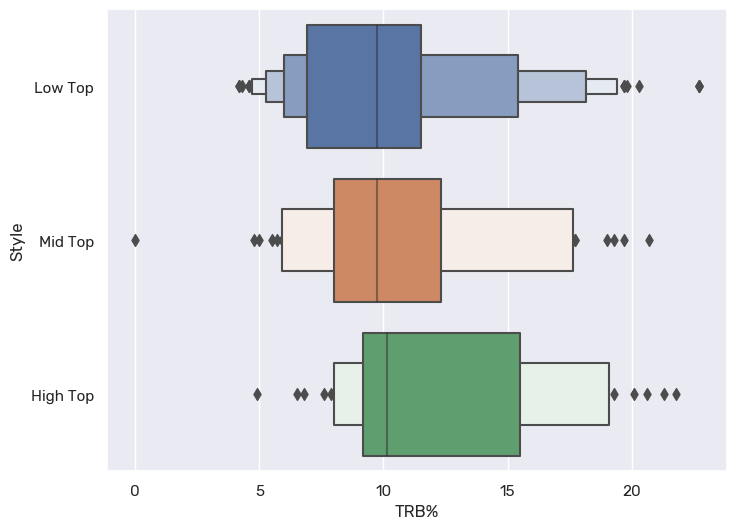

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=df, x='TRB%', y='Style')
fig.savefig('./../../figures/trb_vs_style.png')

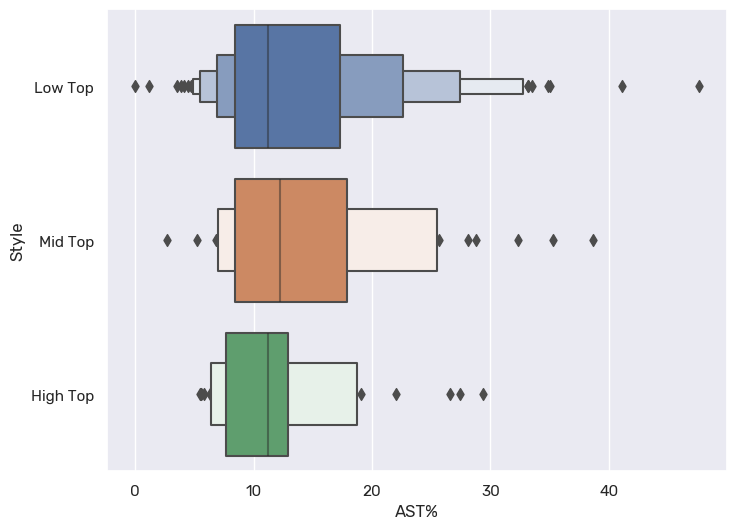

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=df, x='AST%', y='Style')
fig.savefig('./../../figures/ast_vs_style.png')

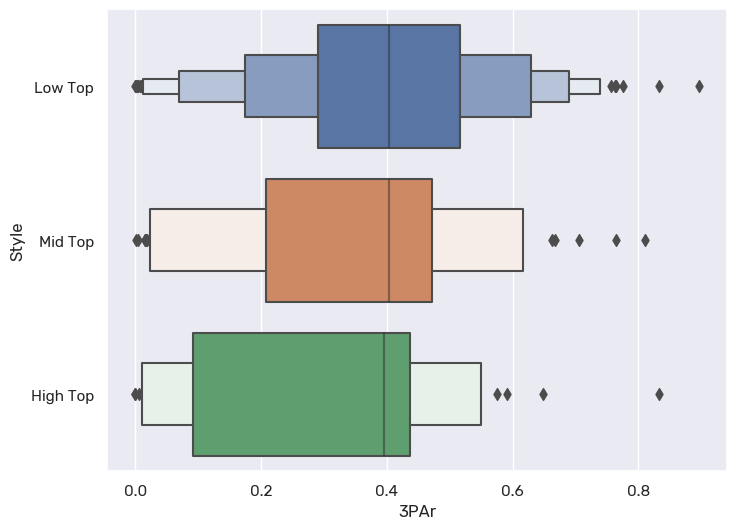

In [91]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=df, x='3PAr', y='Style')
fig.savefig('./../../figures/3par_vs_style.png')

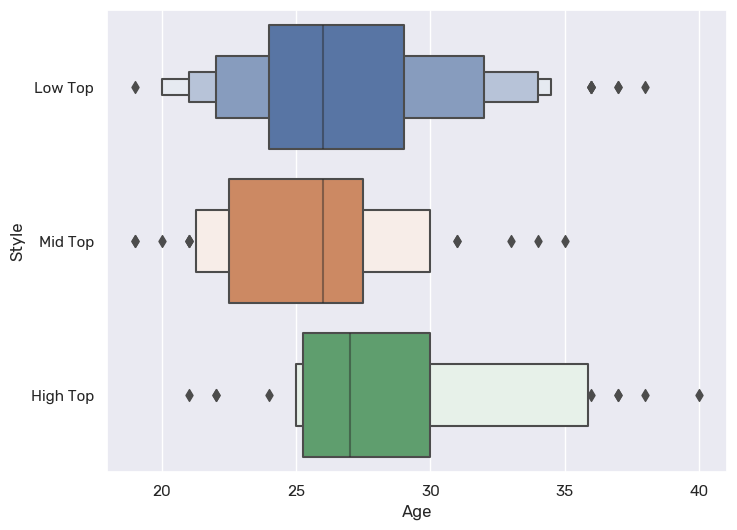

In [105]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxenplot(data=df, x='Age', y='Style')
fig.savefig('./../../figures/age_vs_style.png')

### K-Nearest Neighbors

In [92]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 12}


In [93]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=list(data['Position'].unique())))


0.7346938775510204
              precision    recall  f1-score   support

      Center       0.00      0.00      0.00        11
       Guard       0.73      1.00      0.85        72
     Forward       0.00      0.00      0.00        15

    accuracy                           0.73        98
   macro avg       0.24      0.33      0.28        98
weighted avg       0.54      0.73      0.62        98



### Random Forest

In [94]:
rf=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1)
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}


In [95]:
rf = RandomForestClassifier(max_depth=6, criterion='gini', max_features='auto', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)    
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=list(data['Position'].unique())))

0.7346938775510204
              precision    recall  f1-score   support

      Center       0.00      0.00      0.00        11
       Guard       0.73      1.00      0.85        72
     Forward       0.00      0.00      0.00        15

    accuracy                           0.73        98
   macro avg       0.24      0.33      0.28        98
weighted avg       0.54      0.73      0.62        98



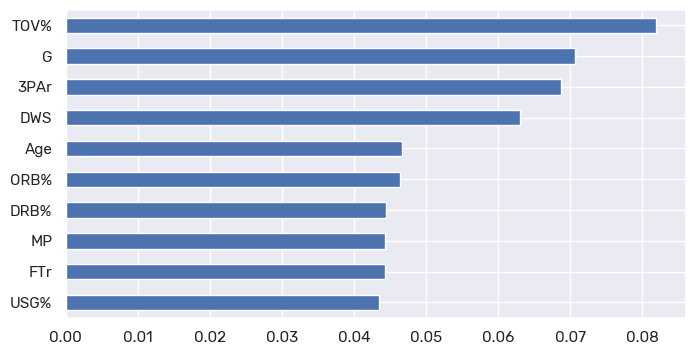

In [96]:
fig, ax = plt.subplots(figsize=(8, 4))
feat_importances = pd.Series(rf.feature_importances_, index=df.columns[1:-3])
ax = feat_importances.nlargest(10).iloc[::-1].plot(kind='barh')
fig.savefig('./../../figures/feature_importances_exp3.png')

### Decision Tree

In [97]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = { 
    'max_depth' : range(1, 10),
    'criterion' :['gini', 'entropy'],
    'max_features': range(1, X_train.shape[1])
}
CV_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, verbose=1)
CV_dt.fit(X_train, y_train)
best_params = CV_dt.best_params_
best_params['min_samples_leaf'] = 1
best_params['min_samples_split'] = 1
print(best_params)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 1}


In [98]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=1, min_samples_split=1, max_features=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, target_names=list(data['Position'].unique())))

0.6938775510204082
              precision    recall  f1-score   support

      Center       0.00      0.00      0.00        11
       Guard       0.73      0.94      0.82        72
     Forward       0.00      0.00      0.00        15

    accuracy                           0.69        98
   macro avg       0.24      0.31      0.27        98
weighted avg       0.54      0.69      0.61        98



### Logistic Regression

In [99]:
clf = LogisticRegression(random_state=42, multi_class='multinomial')
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
CV_lr = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=1)
CV_lr.fit(X_train, y_train)
print(CV_lr.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}


In [100]:
clf = LogisticRegression(random_state=42, multi_class='multinomial', solver='newton-cg', penalty='l2', C=0.001)
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=list(data['Position'].unique())))

0.7346938775510204
              precision    recall  f1-score   support

      Center       0.00      0.00      0.00        11
       Guard       0.73      1.00      0.85        72
     Forward       0.00      0.00      0.00        15

    accuracy                           0.73        98
   macro avg       0.24      0.33      0.28        98
weighted avg       0.54      0.73      0.62        98



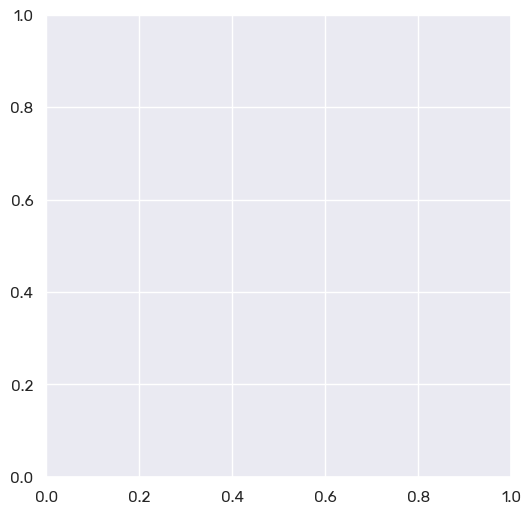

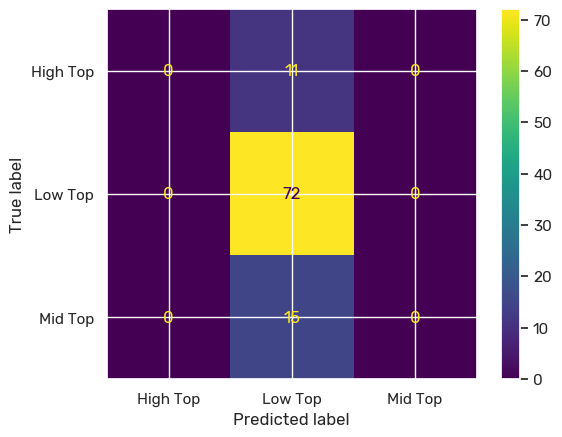

In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(6,6));
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=rf.classes_).plot();
cm.figure_.savefig('./../../figures/confusion_matrix_rf_exp3.png')

In [102]:
proba = knn.predict_proba(X)
y_pred_all = rf.predict(X)
inspect = df[df.iloc[:,-1] != y_pred_all].reset_index(drop=True)
inspect['Predicted'] = y_pred_all[df.iloc[:,-1] != y_pred_all]
inspect

,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,WS,WS/48,OBPM,DBPM,BPM,VORP,Position,Shoe Name,Style,Predicted
0,LaMelo Ball,21.0,36.0,1268.0,17.9,0.541,0.531,0.169,3.5,16.20,...,1.80,0.068,3.2,-0.8,2.40,1.4,Guard,Puma MB.02,Mid Top,Low Top
1,DeAndre Ayton,26.0,62.0,1447.5,14.2,0.579,0.404,0.247,4.1,14.45,...,2.35,0.097,-0.7,0.0,-0.75,0.3,NaN,Puma Rise Nitro,Mid Top,Low Top
2,Killian Hayes,21.0,76.0,2154.0,10.2,0.455,0.351,0.137,1.4,10.20,...,-0.50,-0.012,-3.3,-0.5,-3.80,-1.0,Guard,Puma Rise Nitro,Mid Top,Low Top
3,Mac McClung,24.0,2.0,41.0,19.2,0.563,0.550,0.250,8.8,19.80,...,0.10,0.140,2.2,-1.7,0.50,0.0,Guard,Puma Rise Nitro,Mid Top,Low Top
4,Kevin Porter Jr.,22.0,59.0,2024.0,16.2,0.565,0.436,0.299,4.1,13.10,...,2.90,0.068,1.4,-0.8,0.60,1.3,Guard,Puma Rise Nitro,Mid Top,Low Top
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Jonathan Isaac,25.0,11.0,124.0,20.3,0.483,0.283,0.170,13.7,26.50,...,0.30,0.130,1.0,3.0,4.00,0.2,Forward,Nike Kyrie 5,High Top,Low Top
73,Otto Porter,26.0,62.0,1447.5,14.2,0.579,0.404,0.247,4.1,14.45,...,2.35,0.097,-0.7,0.0,-0.75,0.3,NaN,Jordan Super.Fly MVP L,High Top,Low Top
74,Pau Gasol,38.0,30.0,360.0,16.7,0.529,0.138,0.426,6.7,34.20,...,1.10,0.142,1.0,2.1,3.10,0.5,Center,Nike Hyperdunk X,High Top,Low Top
75,Dirk Nowitzki,40.0,51.0,795.0,9.6,0.469,0.545,0.133,0.7,20.50,...,0.30,0.016,-2.7,-1.2,-3.90,-0.4,Forward,Nike Hyperdunk X,High Top,Low Top
